# **Welcome to the World of Pacman again!! But this time in a python gym environment** (https://www.gymlibrary.ml/)

---



**Install the following libraries in your colab notebook to set up the environment**

In [ ]:
%pip install -U gym>=0.21.0
%pip install -U gym[atari,accept-rom-license]
! apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
! pip install -U colabgymrender
! pip install gym-notebook-wrapper

In [2]:
import random
import gym
from gym.wrappers import RecordVideo
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from IPython.display import display, HTML
import gnwrapper

In [3]:
class ReplayBuffer(object):
    ''' TO LOAD DATA BATCH'''
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, buffer):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = buffer
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
class DQN(nn.Module):
  """
      Your Code HERE
      DEFINE YOUR Deep Q-LEARNING NETWORK HERE which must return Q(S,A) values for each state-action pair
  """
  def __init__(self):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(4,20,5, bias=False)
    self.activation1 = torch.nn.ReLU()
    self.batchnorm1 = torch.nn.BatchNorm2d(20)
    self.conv2 = torch.nn.Conv2d(20,25,5, bias=False)
    self.batchnorm2 = torch.nn.BatchNorm2d(25)
    self.activation2 = torch.nn.LeakyReLU()
    self.flat = nn.Flatten()
    # 174600 is the size of the flattened tensor
    self.linear0 = torch.nn.Linear(174600, 36)
    self.linear1 = torch.nn.Linear(36, 9)

  def feedforward(self,x):
    x = self.activation1(self.batchnorm1(self.conv1(x)))
    x = self.activation1(self.batchnorm2(self.conv2(x)))
    x = self.flat(x)
    x = self.activation2(self.linear0(x))
    return self.linear1(x)

In [16]:
'''
IMPORT NECESSARY DL LIBRARIES e.g torch, tensorflow,etc.
Be careful to change the numpy arrays to tensors wherever required
'''
class Pacman:
    """
        :param gamma: reward discount
        :param batch_size: replay buffer batch sizes
        :param env: gym environment
        :param num_frames: number of frames per state (and number per action)
    """
    def __init__(self, gamma=.99, batch_size=64,
                env='MsPacmanDeterministic-v4', num_frames=4):
        '''
        Code HERE to
        Modify wherever needed
        '''
        self.num_frames = num_frames
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #SPECIFY TRAINING DEVICE to use GPU e.g torch.device('cuda'), tf.device('/device:GPU:0') to train faster 
        self.memory = ReplayBuffer(50000)
        self.gamma = 0.99
        self.batch_size = batch_size
        self.score_history = []
        self.env = gym.make(env)
        self.start = self.get_init_frame()
        _, height, width = len(self.start[0]),len(self.start[1]),len(self.start[2])
        self.num_actions = self.env.action_space.n
        self.policy = DQN().to(self.device)
        self.target = DQN().to(self.device)
        self.epsilon = 0.95
      
        print('Using device:', self.device)
        print()

        #Additional Info when using cuda
        if self.device.type == 'cuda':
            print(torch.cuda.get_device_name(0))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
            
    def info(self):
        print(self.start)
        print(type(self.start))
        print(self.start.shape)

    def get_init_frame(self):
        self.lives = 3
        frame = self.preprocess(self.env.reset())
        frames = []
        for i in range(self.num_frames):
            frames.append(frame)
        return np.array(frames) # there are 4 output frames, each with size 105 x 80

    def preprocess(self, img):
        ds = img[::2,::2] # the 210 x 160 image gets rescaled to 105 x 80
        grayscale = np.mean(ds, axis=-1).astype(np.uint8)
        return np.expand_dims(grayscale, axis=0)

    def fit_model(self, sample):
        policy = self.policy
        target = self.target
        gamma = self.gamma
        dev = self.device # USE THE GPU DEVICE TO TRAIN FASTER
        batchloss=0.0

        states, actions, next_states, rewards, non_terms = list(zip(*sample))
        
        states = np.array(states)
        #convert non_terms to tensor
        non_terms_batch = torch.tensor(non_terms, dtype=torch.int64, device=self.device)

        # non_terms_batch = torch.unsqueeze(non_terms_batch, dim=0)

        #to do: calculate all Q values by feeding states into network
        state_batch = torch.tensor(states, dtype=torch.float32, device=self.device, requires_grad=True)
        state_batch = torch.squeeze(state_batch, dim=1)
        state_batch = torch.squeeze(state_batch, dim=2)
        state_batch = policy.feedforward(state_batch)

        #preprocess next states
        next_states = np.array(next_states)
        next_state_batch = torch.tensor(next_states, dtype=torch.float32, device=self.device, requires_grad=False)
        next_state_batch = torch.squeeze(next_state_batch, dim=1)
        next_state_batch = torch.squeeze(next_state_batch, dim=2)
        next_state_batch = target.feedforward(next_state_batch).max(1)[0].detach() 

        #convert actions to tensor
        actions_batch = torch.tensor(actions, dtype=torch.int64, device = self.device)
        actions_batch= torch.unsqueeze(actions_batch, 1)

        #convert rewards to tensor
        rewards_batch = torch.tensor(rewards, dtype=torch.int64, device=self.device)

        state_batch = state_batch.gather(1,actions_batch)
        state_batch = state_batch.requires_grad_(True)
        #mutliply V values with gamma and add reward 
        V_values = torch.mul((next_state_batch*gamma),1-non_terms_batch)+rewards_batch
        V_values = torch.unsqueeze(V_values, 1)

        #do loss of V values and Q values
        optimizer = torch.optim.Adam(policy.parameters(), lr=0.0001)
        #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.977, last_epoch=- 1, verbose=False) 
        crit = nn.SmoothL1Loss().to(self.device)
        loss = crit(state_batch,V_values)
        batchloss += float(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()

        return batchloss

    def choose_best_action(self, frames):
        '''
        Your Code HERE
        USE DQN MODEL TO predict best_action
        you may would also like to define a eplison 
        to explore options other than best action with some probability
        '''   
        epsilon = self.epsilon
        number = np.random.uniform(low=0.0, high=1.0)
        with torch.no_grad():
          if epsilon > number:
            best_action=self.env.action_space.sample()#THIS IS A Sample action
          else:          
            # frames = torch.mean(torch.tensor(frames, dtype=torch.float, device=self.device), dim=0, keepdim=True)
            # actions = self.policy.feedforward(frames)
            frames = np.array(frames)
            frames = torch.tensor(frames, dtype=torch.float32, device=self.device)
            frames = torch.squeeze(frames, dim=1)
            frames = torch.unsqueeze(frames, dim=0)
            actions = self.policy.feedforward(frames).detach().cpu()
            #best_action = int(np.argmax(actions.detach().cpu().numpy(), axis = 1))
            actions = torch.squeeze(actions, dim=0)
            best_action = int(torch.argmax(actions))
          self.epsilon *= 0.9999
        return best_action
    
    def ability_test(self, frames): 
        frames = np.array(frames)
        frames = torch.tensor(frames, dtype=torch.float32, device=self.device)
        frames = torch.squeeze(frames, dim=1)
        frames = torch.unsqueeze(frames, dim=0)
        actions = self.policy.feedforward(frames).detach().cpu()
        actions = torch.squeeze(actions, dim=0)
        best_action = int(torch.argmax(actions))
        return best_action

    def q_iteration(self, frames, iteration):
        env = self.env
        action = self.choose_best_action(frames)

        is_done = False
        new_frames = []
        total_reward = 0
        total_score = 0
        # Play one game iteration:
        for i in range(self.num_frames):
            if not is_done:
                new_frame, reward, is_done, lives = self.env.step(action)
                lives = lives['lives']
                new_frame = self.preprocess(new_frame)
                total_score += reward
                if lives < self.lives:
                    self.lives = lives
                total_reward += reward
            else:
                reward = 0
            new_frames.append(new_frame)

        non_term = 1
        if is_done:
            non_term = 0
        mem = (np.expand_dims(np.array(frames), axis=0), action,
               np.expand_dims(np.array(new_frames), axis=0), total_reward, non_term)
        self.memory.push(mem)

        loss = None
        # Sample and fit
        if iteration > 64:
            batch = self.memory.sample(self.batch_size)
            loss= self.fit_model(batch) 

        return is_done, total_reward, new_frames, loss

    def train(self, epochs=10000, start_iter=0, updates=500):
        self.score_history = []
        self.loss_hist = []
        self.updates = updates
        self.its_hist = []
        iteration = start_iter
        running_loss = 0
        running_count = 0
        running_score = 0
        running_its = 0
        for e in range(epochs):
            if e<50:
              if e%10 == 0:
                print("Update")
                self.target.load_state_dict(self.policy.state_dict())
            elif e<100:
              if e%25 == 0:
                print("Update")
                self.target.load_state_dict(self.policy.state_dict())
            else:
              if e%30 == 0:
                print("Update")
                self.target.load_state_dict(self.policy.state_dict())
            is_done = False
            e_reward = 0
            e_its = 0
            frames = self.get_init_frame()
            while not is_done:
                is_done, reward, frames, loss = self.q_iteration(frames, iteration)
                iteration += 1
                e_reward += reward
                e_its += 1
                if loss is not None:
                    running_loss += loss
                    running_count += 1
            running_score += e_reward
            running_its += e_its
            era_score = running_score / 10
            era_its = running_its / 10
            self.score_history.append(era_score)
            self.loss_hist.append(running_loss / running_count)
            self.its_hist.append(era_its)
            if e%10 == 0:
                print(f'---> Epoch {e}/{epochs}, Score: {era_score}')
                print(f'-------->Loss: {running_loss / running_count}, Its: {era_its}')
                print(self.epsilon)
                if e%50 == 0:
                    fig, ax = plt.subplots()
                    for i,j in zip(self.loss_hist, range(e)):
                      ax.plot(j, i,color="red", marker="2")
                    ax.set_xlabel("Epochs")
                    ax.set_ylabel("Loss", color="red")
                    ax2=ax.twinx()
                    for i,j in zip(self.score_history, range(e)):
                      ax2.plot(j, i,color="blue", marker="2")    
                    ax2.set_ylabel("Score", color="blue")            
                    plt.show()
            running_loss = 0
            running_count = 0
            running_score = 0
            running_its = 0

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/tor

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.4 GB
Cached:    1.1 GB
Update
---> Epoch 0/151, Score: 48.0
-------->Loss: 4.7731730666341665, Its: 14.4
0.9364173506506351


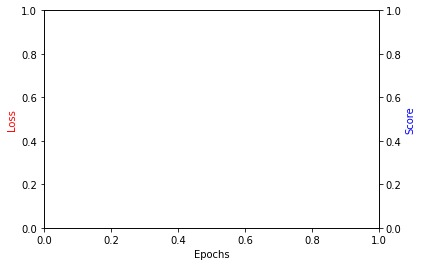

Update
---> Epoch 10/151, Score: 68.0
-------->Loss: 2.7118280979894824, Its: 15.5
0.7959633475596394
Update
---> Epoch 20/151, Score: 93.0
-------->Loss: 2.045985151168912, Its: 17.2
0.6928033540565908
Update
---> Epoch 30/151, Score: 30.0
-------->Loss: 2.461477354319409, Its: 9.9
0.6058542787808467
Update
---> Epoch 40/151, Score: 67.0
-------->Loss: 1.8351346700458053, Its: 16.1
0.5215118502597992
Update
---> Epoch 50/151, Score: 31.0
-------->Loss: 1.4353239080653741, Its: 10.4
0.454194303215583


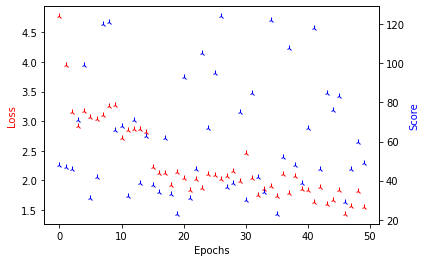

---> Epoch 60/151, Score: 42.0
-------->Loss: 1.5938680927108104, Its: 13.3
0.3986239780741318
---> Epoch 70/151, Score: 32.0
-------->Loss: 1.436442936254927, Its: 12.1
0.34165820993412943
Update
---> Epoch 80/151, Score: 59.0
-------->Loss: 1.1712401952346165, Its: 15.0
0.2997666416353697
---> Epoch 90/151, Score: 79.0
-------->Loss: 1.3222379193913123, Its: 16.1
0.25930294766701284
---> Epoch 100/151, Score: 45.0
-------->Loss: 1.552234422582299, Its: 13.4
0.22499765159477175


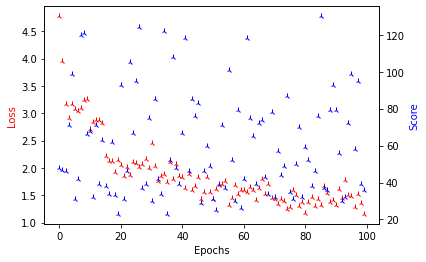

---> Epoch 110/151, Score: 60.0
-------->Loss: 1.3358835771916404, Its: 18.9
0.19526993420742075
Update
---> Epoch 120/151, Score: 57.0
-------->Loss: 1.3623878199607133, Its: 16.0
0.1681868247850895
---> Epoch 130/151, Score: 30.0
-------->Loss: 1.4087467128938098, Its: 10.6
0.141665243348109
---> Epoch 140/151, Score: 117.0
-------->Loss: 1.411250378917809, Its: 19.9
0.12038063640126591
Update
---> Epoch 150/151, Score: 40.0
-------->Loss: 1.3183620723861236, Its: 10.8
0.10435009534558394


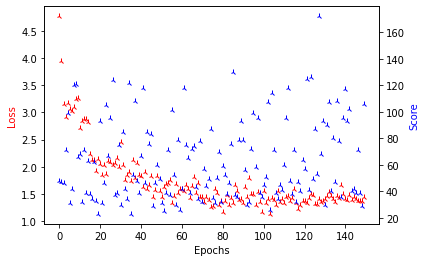

/usr/local/lib/python3.7/dist-packages/gym/core.py:50: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  "You are calling render method, "
/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:298: UserWarning: WARN: No render fps was declared in the environment (env.metadata

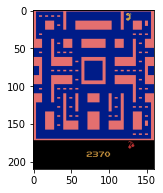

In [17]:
pacman = Pacman()
pacman.train(151)

def mini_it(frames):
        action = pacman.ability_test(frames)

        is_done = False
        new_frames = []
        total_reward = 0
        total_score = 0
        # Play one game iteration:
        for i in range(pacman.num_frames):
            if not is_done:
                new_frame, reward, is_done, lives = pacman.env.step(action)
                lives = lives['lives']
                new_frame = pacman.preprocess(new_frame)
                total_score += reward
                if lives < pacman.lives:
                    pacman.lives = lives
                total_reward += reward
            else:
                reward = 0
            new_frames.append(new_frame)

        non_term = 1
        return is_done, total_reward, new_frames

env = gnwrapper.LoopAnimation(pacman.env)

frames = pacman.get_init_frame()
is_done = False

while not is_done:
      is_done, reward, frames = mini_it(frames)
      env.render()

env.display()